# Сравнение мощности методов анализа метрики среднего чека

В данном ноутбуке мы сравним мощность четырех методов анализа метрики среднего чека:
1. Линеаризация
2. Бутстрап
3. Бакетизация
4. Дельта-метод

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Настройки для графиков
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set(font_scale=1.2)

In [3]:
# Загрузка данных
logs = pd.read_pickle('aa_test_logs.pkl')

# Подготовка данных для анализа
def prepare_data(logs):
    # Находим платящих пользователей
    purchase_events = logs[logs['event'] == 'cart-paid']
    paid_carts = purchase_events['cart_id'].unique()
    
    # Находим все события добавления товаров в оплаченные корзины
    cart_add_events = logs[
        (logs['event'] == 'cart-add') & 
        (logs['cart_id'].isin(paid_carts))
    ]
    
    # Группируем по пользователям и считаем сумму покупок
    user_revenue = cart_add_events.groupby(['user_id', 'group'])['amount'].sum().reset_index()
    
    # Разделяем на контрольную и тестовую группы
    control_data = user_revenue[user_revenue['group'] == 'control']['amount']
    test_data = user_revenue[user_revenue['group'] == 'test']['amount']
    
    return control_data, test_data

control_data, test_data = prepare_data(logs)

In [4]:
# Метод 1: Линеаризация (t-тест)
def linearization_test(control_data, test_data):
    t_stat, p_value = stats.ttest_ind(control_data, test_data, equal_var=False)
    return p_value

# Метод 2: Бутстрап
def bootstrap_test(control_data, test_data, n_bootstrap=1000):
    # Вычисляем разницу средних в исходных данных
    observed_diff = np.mean(test_data) - np.mean(control_data)
    
    # Объединяем данные
    combined = np.concatenate([control_data, test_data])
    n_control = len(control_data)
    
    # Бутстрап
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        # Перемешиваем данные
        np.random.shuffle(combined)
        # Разделяем на группы той же длины
        boot_control = combined[:n_control]
        boot_test = combined[n_control:]
        # Считаем разницу средних
        boot_diff = np.mean(boot_test) - np.mean(boot_control)
        bootstrap_diffs.append(boot_diff)
    
    # Считаем p-value как долю бутстрап-разниц, превышающих наблюдаемую разницу
    p_value = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
    return p_value

# Метод 3: Бакетизация
def bucketization_test(control_data, test_data, n_buckets=20):
    # Создаем бакеты для каждой группы
    def create_buckets(data, n_buckets):
        bucket_size = len(data) // n_buckets
        buckets = []
        for i in range(n_buckets):
            start_idx = i * bucket_size
            end_idx = start_idx + bucket_size if i < n_buckets - 1 else len(data)
            buckets.append(np.mean(data[start_idx:end_idx]))
        return np.array(buckets)
    
    # Создаем бакеты и проводим t-тест
    control_buckets = create_buckets(control_data, n_buckets)
    test_buckets = create_buckets(test_data, n_buckets)
    
    t_stat, p_value = stats.ttest_ind(control_buckets, test_buckets, equal_var=False)
    return p_value

# Метод 4: Дельта-метод
def delta_method_test(control_data, test_data):
    # Вычисляем средние и стандартные ошибки
    control_mean = np.mean(control_data)
    test_mean = np.mean(test_data)
    control_se = np.std(control_data, ddof=1) / np.sqrt(len(control_data))
    test_se = np.std(test_data, ddof=1) / np.sqrt(len(test_data))
    
    # Вычисляем z-статистику
    z_stat = (test_mean - control_mean) / np.sqrt(control_se**2 + test_se**2)
    
    # Вычисляем p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return p_value

In [5]:
# Функция для оценки мощности
def estimate_power(method, control_data, test_data, effect_size, n_simulations=500):
    significant_results = 0
    
    for _ in tqdm(range(n_simulations), desc=f'Оценка мощности для эффекта {effect_size:.2f}'):
        # Создаем копии данных
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        test_sample = np.random.choice(test_data, size=len(test_data), replace=True)
        
        # Добавляем эффект к тестовой группе
        test_sample_with_effect = test_sample * (1 + effect_size)
        
        # Проводим тест
        p_value = method(control_sample, test_sample_with_effect)
        
        # Если p-value < 0.05, считаем результат значимым
        if p_value < 0.05:
            significant_results += 1
    
    # Возвращаем мощность как долю значимых результатов
    return significant_results / n_simulations

In [6]:
# Сравнение мощности методов
effect_sizes = np.arange(0.01, 0.31, 0.05)  # от 1% до 30% с шагом 5%
methods = {
    'Линеаризация': linearization_test,
    'Бутстрап': bootstrap_test,
    'Бакетизация': bucketization_test,
    'Дельта-метод': delta_method_test
}

# Вычисляем мощность для каждого метода и размера эффекта
results = {}
for method_name, method_func in methods.items():
    print(f'\nОценка мощности для метода: {method_name}')
    method_powers = []
    for effect in effect_sizes:
        power = estimate_power(method_func, control_data, test_data, effect)
        method_powers.append(power)
    results[method_name] = method_powers


Оценка мощности для метода: Линеаризация


Оценка мощности для эффекта 0.26: 100%|██████████| 500/500 [00:00<00:00, 1745.89it/s]



Оценка мощности для метода: Бутстрап


Оценка мощности для эффекта 0.26: 100%|██████████| 500/500 [00:21<00:00, 23.10it/s]



Оценка мощности для метода: Бакетизация


Оценка мощности для эффекта 0.26: 100%|██████████| 500/500 [00:00<00:00, 1292.88it/s]



Оценка мощности для метода: Дельта-метод


Оценка мощности для эффекта 0.26: 100%|██████████| 500/500 [00:00<00:00, 11133.39it/s]


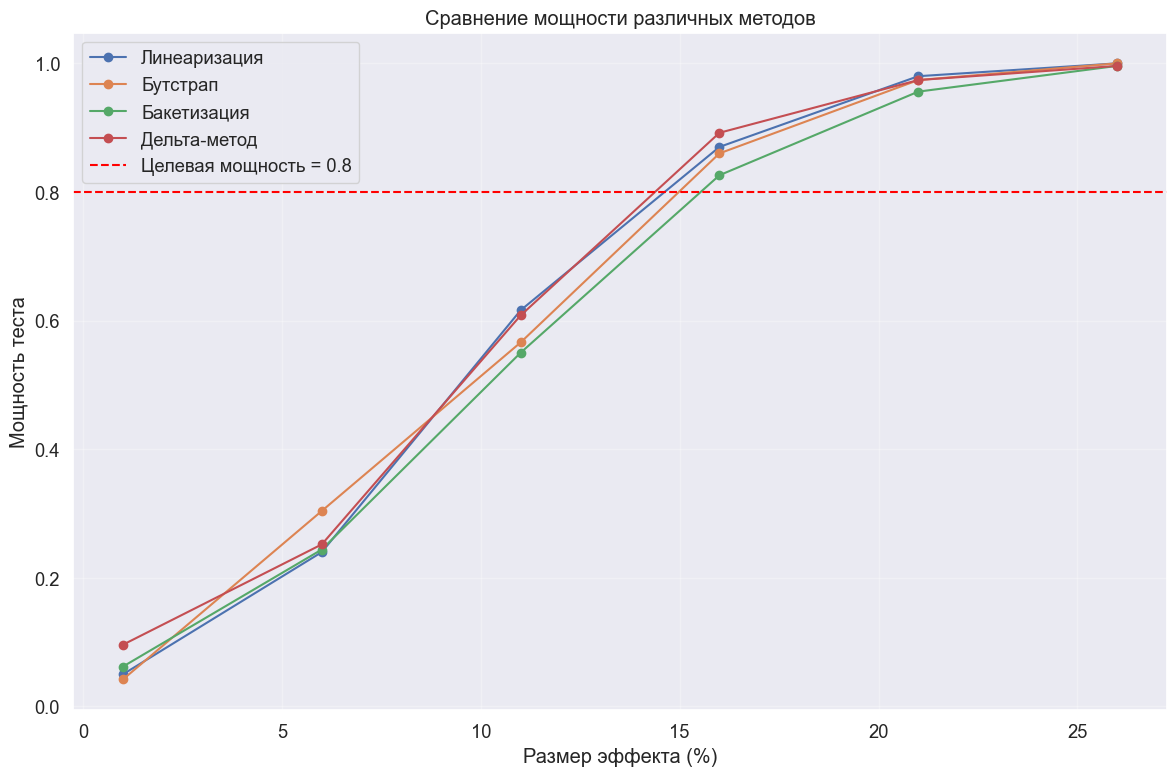

In [7]:
# Визуализация результатов
plt.figure(figsize=(12, 8))
for method_name, powers in results.items():
    plt.plot(effect_sizes * 100, powers, marker='o', label=method_name)

plt.axhline(0.8, color='red', linestyle='--', label='Целевая мощность = 0.8')
plt.xlabel('Размер эффекта (%)')
plt.ylabel('Мощность теста')
plt.title('Сравнение мощности различных методов')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('power_comparison.png')
plt.show()

Скорость выполнения методов:

Линеаризация показывает самую высокую производительность: 
~1600-1700 итераций в секунду

Бутстрап значительно медленнее: ~23 итерации в секунду
Это объясняется тем, что бутстрап требует многократного пересэмплирования данных